STUDENT NAME: Raymond Shum

CLASS: CST383-30_SP22

ASSIGNMENT: Week 7 - Lab 2

DUE DATE: Feb. 22, 2022

#### 1. We defined the Gini index value for a node in a classification tree as...

`2p(1-p)`

Where p is the estimated probability of either of the two classes.  For example, if a node has 30 training instances of class A, and 50 training instances of class B, then the estimated probability of class A is 30/(30 + 50).  What is the Gini index value for this node?

In [1]:
def gini(class_counts):
    total = sum(class_counts)
    p = class_counts[0]/total
    return 2 * p * (1 - p)

In [2]:
# test with class example
class_counts = [5, 1]
round(gini(class_counts), 2) # Should be 28


0.28

#### 2. Create a new Python file.  Fill in the code below to create a function that gives the Gini value for a node in a binary classification tree given values for the number of instances of each class.  class_counts is a list of length two.

In [3]:
# I like Geron's better because it can also deal with the textbook example
# I'm using 1 - p_a**2 - p_b**2
def gini(class_counts):
    total = sum(class_counts)
    result = 0
    for cls in class_counts:
        result -= (cls/total)**2
    return 1 + result

#### 3. Test your function.  What is gini([30, 50])? gini([10, 10])?  What is gini([20, 0])?  What is gini([100, 0])? 

In [4]:
# class example: 
print(round(gini([5,1]), 2)) # assert .28

# textbook example (from Fig 1-6):
print(round(gini([50,50,50]), 3)) # assert .667
print(round(gini([50,0,0]), 3)) # assert 0
print(round(gini([0,50,50]), 3)) # assert .5
print(round(gini([0,49,5]), 3)) # assert .168
print(round(gini([0,1,45]), 3)) # assert .043

0.28
0.667
0.0
0.5
0.168
0.043


In [5]:
# test with problem 3 params
test_params = [
    [30,50],
    [10,10],
    [20,0],
    [100,0]
]

for class_count in test_params:
    a, b = class_count
    print(f'gini [{a}, {b}] = {gini(class_count):.2f}')

gini [30, 50] = 0.47
gini [10, 10] = 0.50
gini [20, 0] = 0.00
gini [100, 0] = 0.00


#### 4. Add the following code at the top of your file to read and preprocess the data.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
import graphviz

<AxesSubplot:xlabel='age', ylabel='maxhr'>

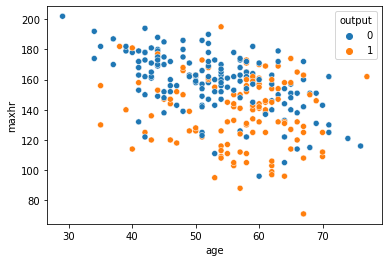

In [7]:
df = pd.read_csv("https://raw.githubusercontent.com/grbruns/cst383/master/heart.csv")
df['output'] = df['output'] - 1

df = df[['age', 'maxhr', 'restbp', 'output']]
sns.scatterplot(x='age', y='maxhr', hue='output', data=df)

#### 5. Run the code and look at the plot.  If we were going to build a classification tree, and split first on 'age', what do you think a good age value to split on would be?

With the goal of maximizing homogeneity, I would like to split at 52 or so. At first glance, it looks like most "1" samples are to the right of the split while most 0 samples are to the left. 

#### 6. Compute the Gini index for df as a whole.  For this you just need the number of rows with output = 0 and the number of rows with output = 1.

In [8]:
class_counts = []
for cls in df['output'].value_counts():
    class_counts.append(cls)
print(f'gini: {gini(class_counts):.3f}')

gini: 0.494


#### 7. Now consider a split on age < 50.  Write code to compute the Gini index for the case of of age < 50 and the Gini index for the case of age >= 50.  For the case of age < 50, get the rows of df where age < 50, then count the number of rows with output = 0 and output = 1.  

In [9]:
def split_on_age(df, split):
    mask_gt = df['age'] >= split
    mask_lt = ~mask_gt

    class_counts_lt = df[mask_lt]['output'].value_counts()
    gini_lt = gini(class_counts_lt)

    class_counts_gt = df[mask_gt]['output'].value_counts()
    gini_gt = gini(class_counts_gt)
    
    return gini_lt, gini_gt, class_counts_lt, class_counts_gt

gini_lt, gini_gt,class_counts_lt, class_counts_gt = split_on_age(df,50)

print(f'(age < 50): {gini_lt:.3f}')
print(f'(age >= 50): {gini_gt:.3f}')

(age < 50): 0.413
(age >= 50): 0.500


#### 8. Now compute the overall Gini index value for the split on age < 50.  First you need to compute the fraction of nodes associated with age < 50 (call it fraction_lo) and the fraction of nodes associated with age >= 50 (call it fraction_hi).  Then get the Gini value for the split like this (in pseudo code):

`gini_split = gini_lo * fraction_lo + gini_hi * fraction_hi`

The split is useful if the Gini value for the split is lower than the GIni value for the root.

In [10]:
def gini_split(gini_lo, class_counts_lt, gini_hi, class_counts_gt):
    total = sum(class_counts_lt) + sum(class_counts_gt)
    fraction_lo = sum(class_counts_lt) / total
    fraction_hi = sum(class_counts_gt) / total
    return gini_lo * fraction_lo + gini_hi * fraction_hi

gini_split(gini_lt, class_counts_lt, gini_gt, class_counts_gt)

0.47438531380475835

In [11]:
# test using class slides

# split 1
print(round(gini_split(.41, [207], .20, [570]), 2)) # assert 0.25 (got .26)

# split 2
print(round(gini_split(.22, [609], .30, [168]), 2)) # assert 0.23 (got .24)

0.26
0.24


#### 9. Is a split on age < 40 better than a split on age < 50?

In [14]:
ages = [40, 50]
for age in ages:
    gini_lt, gini_gt,class_counts_lt, class_counts_gt = split_on_age(df, age)
    index_gini = gini_split(gini_lt, class_counts_lt, gini_gt, class_counts_gt)
    print(f'gini for split on (age < {age}): {index_gini:.3f}')

gini for split on (age < 40): 0.493
gini for split on (age < 50): 0.474


#### 10. Compute the Gini value for all age splits where age ranges from 20 to 80.  Then plot the Gini split value for all the ages (age on x axis, Gini value on y axis).  What is the best age value for a split on age?

In [42]:
ages = range(20,81)
gini_scores = []
for age in ages:
    gini_lt, gini_gt,class_counts_lt, class_counts_gt = split_on_age(df, age)
    index_gini = gini_split(gini_lt, class_counts_lt, gini_gt, class_counts_gt)
    gini_scores.append(index_gini)
    
min_score = np.min(gini_scores)
idx = np.where(gini_scores == min_score)

print(f'Age: {ages[index[0][0]]} | Score: {min_score:.3f}')

Age: 55 | Score: 0.456


#### 11. If you still have time, do the same thing for features 'maxhr' and 'restbp'.  What is the best feature and best split?